In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.metrics import scores
%matplotlib inline

In [ ]:
from nmt_run import *

In [3]:
model_files = [f for f in os.listdir(os.path.dirname(model_fil))
                   if os.path.basename(model_fil).replace('.model','') in f]
print(model_files)

['seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_2_2_2DCNN_BN_LN_enc-3_10.model', 'seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_2_2_2DCNN_BN_LN_enc-3_20.model', 'seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_2_2_2DCNN_BN_LN_enc-3_30.model']


In [4]:
max_model_fil = max(model_files, key=lambda s: int(s.split('_')[-1].split('.')[0]))

In [5]:
max_model_fil

'seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_2_2_2DCNN_BN_LN_enc-3_30.model'

In [6]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_fbank/seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_2_2_2DCNN_BN_LN_enc-3_30.model
loading ...
finished loading ..


In [7]:
log_dev_fil_name

'fsh_fbank/dev_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_2_2_2DCNN_BN_LN_enc-3.log'

In [8]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.loadtxt(log_dev_fil_name, delimiter=',', skiprows=5).transpose()

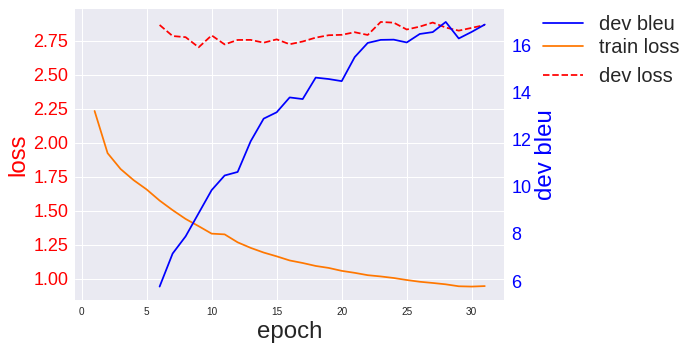

In [9]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax2.set_ylim(0, 0.9)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [10]:
key='fisher_dev'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])

In [11]:
cat_speech_path = os.path.join(out_path, key)

In [12]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
pred_sents, utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|          | 0/3977 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 31


b=4,l=2.47,avg=2.86: 100%|██████████| 3977/3977 [02:05<00:00, 15.58it/s] 

********** dev mean loss=2.8556
-
--------------------------------------------------------------------------------


In [13]:
display_words(m_dict, v_dict, pred_sents[-50:], utts[-50:], dec_key)

Utterance: 20051009_182032_217_fsp-B-47
+---------+--------------------------------------------------+
| es ref  | le pedíamos a papá dios por nosotros por toda la |
|         | familia                                          |
+---------+--------------------------------------------------+
| en ref  | we asked father god for us for all our family    |
+---------+--------------------------------------------------+
| en pred | ¿would our dad forgives pictures                 |
+---------+--------------------------------------------------+
Utterance: 20051009_210519_219_fsp-B-48
+---------+-------------------------------------------------+
| es ref  | ya cuando él sea adulto ya él decida lo que él  |
|         | quiere hacer                                    |
+---------+-------------------------------------------------+
| en ref  | when he is already an adult then he will decide |
|         | what he wants to do                             |
+---------+---------------------------------

In [22]:
b, h, r = calc_bleu(m_dict, v_dict, pred_sents[:n], utts[:n], dec_key)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))

print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
for weights in all_weights:
    b = corpus_bleu(r, h, weights=weights)
    print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

BLEU score on: fisher_dev = 16.57
------------------------------------------------------------
  bleu score (0-100) | uni-bi-tri-quad     
               49.62 | 1.00-0.00-0.00-0.00 
               23.21 | 0.00-1.00-0.00-0.00 
               11.45 | 0.00-0.00-1.00-0.00 
                5.73 | 0.00-0.00-0.00-1.00 
               33.93 | 0.50-0.50-0.00-0.00 
               23.62 | 0.33-0.33-0.33-0.00 
               16.57 | 0.25-0.25-0.25-0.25 


In [16]:
_, _ = corpus_precision_recall(r, h)

metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    53.97 |    25.24|    12.45 |     6.23
recall     |    45.78 |    21.15|    10.32 |     5.10


### Test code

In [23]:
# test_ref = [["ha ha lol hue".split()], ["ha ha ja ha".split()], ["ha ha ja ha".split()]]
# test_h = ["lol ja".split(), "ha he".split(), "ha ja".split()]
# _, _ = corpus_precision_recall(test_ref, test_h)